# Image captioning app 🎨

## Introduction
This notebook demonstrates how to build an `Image Captioning application` using Hugging Face and Gradio.
The task involves generating descriptive captions for images using machine learning models hosted on Hugging Face. We will walk through the process of setting up the environment, loading necessary libraries, and creating a web interface using Gradio.

### Install and Import Libraries
Here is a brief description of the required libraries:
- The trasformers library is a library by Hugging Face that provides pre-trained models and tools for natural language processing (NLP) and other tasks such as computer vision and audio processing. 

- The python-dotenv library is used to load environment variables from a .env file into your application's environment. It helps manage sensitive configuration details like API keys and database credentials.

- The Gradio library is a library for building user-friendly web-based interfaces for machine learning models and data pipelines. It allows you to create interactive demos with minimal code. 

In [1]:
# Install and update the necessary libraries
%pip install python-dotenv gradio

Note: you may need to restart the kernel to use updated packages.


- Loading API Keys and Libraries

In [1]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv())

import os # Provides a way of using operating system-dependent functionality
import io # Provides core tools for working with streams of data
from io import BytesIO
import IPython.display # Used for displaying rich content (e.g., images, HTML) in Jupyter Notebooks
from PIL import Image # Python Imaging Library for opening, manipulating, and saving image files
import base64 # Encodes and decodes data in base64 format
import requests
import json
import torch
import torch.nn as nn
import warnings
import gradio as gr

# Ignore specific UserWarnings related to max_length in transformers
warnings.filterwarnings("ignore", message=".*Using the model-agnostic default `max_length`.*")

# Load environment variables from .env file
hf_api_key = os.getenv('HF_API_KEY')
endpoint_url = os.getenv('HF_API_ITT_BASE')
port1 = int(os.getenv('PORT1', 7860))
port2 = int(os.getenv('PORT2', 7870))

# Uncomment the following line to print HF API Key, Endpoint URL and Port1
#print("HF API Key:", hf_api_key)
#print("Endpoint URL:", endpoint_url)
#print("Port:", port1)
#print("Port:", port2)

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The HF_API_ITT_BASE for the image-to-text endpoint is related to the choosen model from image-to-text section that is available on the Hugging Face website's. Here, the selected model is Salesforce/blip-image-captioning-large, which is currently widely used. The corresponding API URL is:"https://api-inference.huggingface.co/models/Salesforce/blip-image-captioning-large"

### Helper Functions

In [2]:
#Image-to-text endpoint
def get_completion(inputs, parameters=None, endpoint_url=endpoint_url):
    headers = {
        "Authorization": f"Bearer {hf_api_key}",
        "Content-Type": "application/json"
    }
    data = {"inputs": inputs}
    if parameters is not None:
        data.update({"parameters": parameters})
    response = requests.post(endpoint_url, headers=headers, data=json.dumps(data))
    return json.loads(response.content.decode("utf-8"))

def get_generation(model, processor, image, dtype):
    inputs = processor(image, return_tensors="pt").to(dtype)
    out = model.generate(**inputs)
    return processor.decode(out[0], skip_special_tokens=True)

def load_image(img_url):
    image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')
    return image

### Building the Image Captioning App

Here we'll be using an [Inference Endpoint](https://huggingface.co/inference-endpoints) for `Salesforce/blip-image-captioning-base` a 14M parameter captioning model.


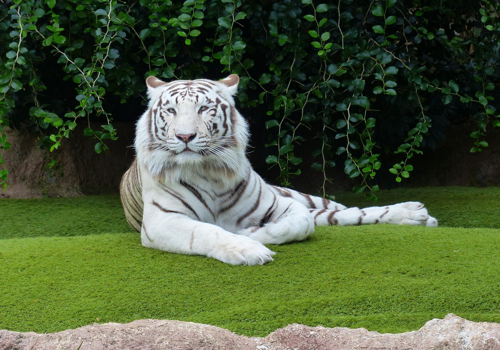

[{'generated_text': 'there is a white tiger laying on the grass in the zoo'}]


In [3]:
image_url = 'https://free-images.com/lg/9e46/white_bengal_tiger_tiger_0.jpg'
image = load_image(image_url)
display(image.resize((500, 350)))

caption = get_completion(image_url)
print(caption)

### Gradio Interface

In [4]:
def caption_image(image_url):
    # Download the image from the URL
    response = requests.get(image_url)
    response.raise_for_status()  # Ensure the request was successful
    image = Image.open(BytesIO(response.content))  # Load image with PIL
    
    # Call your captioning function here (replace `get_completion` with the actual implementation)
    #caption = get_completion(image)
    caption = get_completion(image_url)
    return caption

iface = gr.Interface(
    fn=caption_image,
    inputs=gr.Textbox(label="Image URL"),  # Input as a URL
    outputs="text",
    title="Image Captioning"
)

iface.launch(share=True)

* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://914fb940550900965c.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [5]:
gr.close_all()

Closing server running on port: 7860


## Example with three images 

- Load Images 

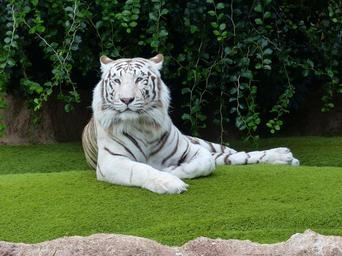

In [6]:
#Image1
image1 = Image.open('./Building_Generative_AI_Applications_with_Gradio/Image_Captioning_app/white_bengal_tiger.jpg')
image1

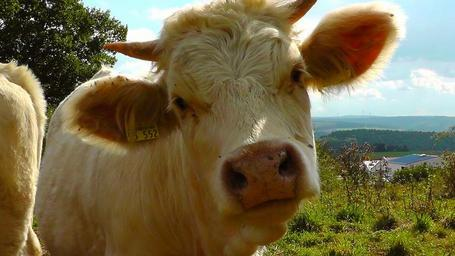

In [7]:
#Image2
image2 = Image.open('./Building_Generative_AI_Applications_with_Gradio/Image_Captioning_app/cow.jpeg')
image2

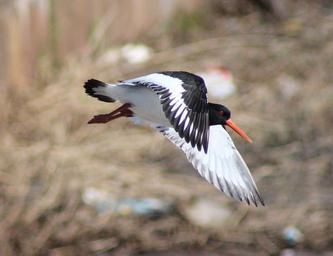

In [8]:
#Image3
image3 = Image.open('./Building_Generative_AI_Applications_with_Gradio/Image_Captioning_app/bird_flight.jpeg')
image3

- Gradio Interface

#### Captioning with `gr.Interface()`

#### gr.Image()
- The `type` parameter is the format that the `fn` function expects to receive as its input.  If `type` is `numpy` or `pil`, `gr.Image()` will convert the uploaded file to this format before sending it to the `fn` function.
- If `type` is `filepath`, `gr.Image()` will temporarily store the image and provide a string path to that image location as input to the `fn` function.
- gr.Image requires the installation of gradio and the set up of a custom PORT1 environment variable. 

In [9]:
def image_to_base64_str(pil_image):
    byte_arr = io.BytesIO()
    pil_image.save(byte_arr, format='PNG')
    byte_arr = byte_arr.getvalue()
    return str(base64.b64encode(byte_arr).decode('utf-8'))

def captioner(image):
    base64_image = image_to_base64_str(image)
    result = get_completion(base64_image)
    return result[0]['generated_text']

gr.close_all()
demo = gr.Interface(fn=captioner,
                    inputs=[gr.Image(label="Upload image", type="pil")],
                    outputs=[gr.Textbox(label="Caption")],
                    title="Image Captioning with BLIP",
                    description="Caption any image using the BLIP model",
                    allow_flagging="never",
                    examples=[image1, image2, image3])                  

demo.launch(share=True, inline=True, server_port=int(os.environ['PORT1']))


Closing server running on port: 7860


/usr/local/python/3.12.1/lib/python3.12/site-packages/gradio/interface.py:399: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://3692912cb21cbbfe0a.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [10]:
#Close the app
gr.close_all()

Closing server running on port: 7860
Closing server running on port: 7860


The free images are available on: https://free-images.com/

## Conclusion
In this notebook, we built an Image Captioning application using Hugging Face and Gradio. 
The application utilizes the Salesforce/blip-image-captioning-base model to generate captions 
for images provided by the user. We demonstrated how to set up the environment, load required libraries, 
and create a user-friendly interface with Gradio. This approach enables the deployment of powerful AI models 
for practical applications in a straightforward manner. For more information, refer to the Hugging Face Documentation and Gradio Documentation.

### Next stpes
- Experiment with Different Models: Try using other image captioning models available on Hugging Face to see how their performance compares!
- Deploy the App: Deploy your Gradio app to Hugging Face Spaces or another hosting service to make it accessible to others!